In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, Input

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix, roc_curve, roc_auc_score, auc, classification_report
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, BatchNormalization

from keras.utils import plot_model
from keras import backend as K
import keras

%matplotlib  inline

#random seed
np.random.seed(42)

2023-08-26 17:15:07.385480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 17:15:08.256909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("writeData.csv")

In [3]:
df.head()

,Unnamed: 0,78,235,4.1,22,2,219,0,22.1,69,287,1
0,0,264,1468,23,22,10,581,1,22,255,338,1
1,1,94,192,16,12,11,141,3,12,93,247,1
2,2,124,434,136,16,4,234,21,16,105,318,1
3,3,105,251,34,14,16,301,9,14,89,263,1
4,4,80,374,10,11,106,233,3,11,76,305,1


In [4]:
print("Shape of dataset: ",df.shape)

Shape of dataset:  (7199, 12)


In [5]:
df.columns

Index(['Unnamed: 0', '78', '235', '4.1', '22', '2', '219', '0', '22.1', '69',
       '287', '1'],
      dtype='object')

In [6]:
df['1'].unique()

array([ 1, -1])

In [7]:
# checking null values
df.isnull().sum().sum()

0

In [8]:
# after removing nan values
df['1'].unique()

array([ 1, -1])

In [9]:
df['1'].value_counts()

1
 1    7064
-1     135
Name: count, dtype: int64

In [10]:
df['1'] = df['1']*-1
df['1'].value_counts()

1
-1    7064
 1     135
Name: count, dtype: int64

In [11]:
print("length of dataset: ", len(df))

length of dataset:  7199


In [12]:
# checking null values
df.isnull().sum()

Unnamed: 0    0
78            0
235           0
4.1           0
22            0
2             0
219           0
0             0
22.1          0
69            0
287           0
1             0
dtype: int64

In [13]:
df.dtypes

Unnamed: 0    int64
78            int64
235           int64
4.1           int64
22            int64
2             int64
219           int64
0             int64
22.1          int64
69            int64
287           int64
1             int64
dtype: object

In [14]:
y = df['1'].values
X = df.drop(columns = ["Unnamed: 0", "1"]).values

In [15]:
X.shape, y.shape

((7199, 10), (7199,))

In [16]:
# Noramlize X values in the range (0,1)
sc = MinMaxScaler(feature_range = (0, 1))
X_scaled = sc.fit_transform(X)


In [17]:
X_scaled.shape

(7199, 10)

In [18]:
num_classes = len(np.unique(y))
num_classes

2

In [19]:
# Reshape the data for LSTM (samples, timesteps, features)
sequence_length = 10 # Number of timesteps
X_seq = np.array([X_scaled[i:i+sequence_length, :] for i in range(len(X_scaled) - sequence_length + 1)])
y_seq = y[sequence_length - 1:]

In [20]:
X_seq.shape, y_seq.shape

((7190, 10, 10), (7190,))

In [21]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.15, random_state = 42)

In [22]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)


Shape of X_train:  (6111, 10, 10)
Shape of X_test:  (1079, 10, 10)
Shape of y_train:  (6111,)
Shape of y_test:  (1079,)


In [23]:
# After reshaping
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)


Shape of X_train:  (6111, 10, 10)
Shape of X_test:  (1079, 10, 10)
Shape of y_train:  (6111,)
Shape of y_test:  (1079,)


In [24]:
# Now we shuffle the training set because we will be using the validation_split option later when training.
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [25]:
# Standardize the labels to positive integers. The expected labels will then be 0 and 1.
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0


In [26]:
X_train.shape[1:], X_train.shape[2]

((10, 10), 10)

In [27]:
input_shape = X_train.shape[1:]
input_shape

(10, 10)

2023-08-26 17:15:13.519501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-26 17:15:13.587642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-26 17:15:13.587932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

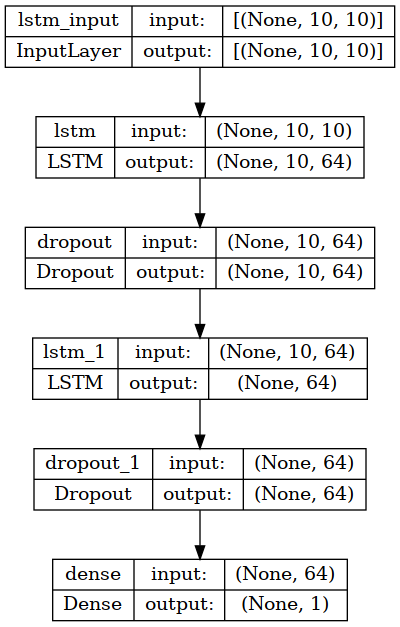

In [28]:
# Create an LSTM model with two hidden layers and dropout
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Dropout for the first LSTM layer

model.add(LSTM(64))
model.add(Dropout(0.2))  # Dropout for the second LSTM layer
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

plot_model(model, to_file="LSTM_model_feature_selection.png", show_shapes=True)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            19200     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 52,289
Trainable params: 52,289
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [30]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_500_epoches_feature_selection.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss = 'mean_squared_error', 
    metrics = ["accuracy"],
)
history1 = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
#     callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500


2023-08-26 17:15:15.341080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 17:15:15.342774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 17:15:15.344660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

151/153 [============================>.] - ETA: 0s - loss: 0.0324 - accuracy: 0.9770

2023-08-26 17:15:21.017442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 17:15:21.019610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 17:15:21.021461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

153/153 [==============================] - 7s 19ms/step - loss: 0.0321 - accuracy: 0.9773 - val_loss: 0.0180 - val_accuracy: 0.9820
Epoch 2/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0184 - accuracy: 0.9816 - val_loss: 0.0178 - val_accuracy: 0.9820
Epoch 3/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0181 - accuracy: 0.9816 - val_loss: 0.0176 - val_accuracy: 0.9820
Epoch 4/500
153/153 [==============================] - 2s 13ms/step - loss: 0.0180 - accuracy: 0.9816 - val_loss: 0.0176 - val_accuracy: 0.9820
Epoch 5/500
153/153 [==============================] - 2s 13ms/step - loss: 0.0180 - accuracy: 0.9816 - val_loss: 0.0175 - val_accuracy: 0.9820
Epoch 6/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0180 - accuracy: 0.9816 - val_loss: 0.0176 - val_accuracy: 0.9820
Epoch 7/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0181 - accuracy: 0.9816 - val_loss: 0.0178 - val_accuracy: 0.9820
Epoc

153/153 [==============================] - 2s 14ms/step - loss: 0.0177 - accuracy: 0.9816 - val_loss: 0.0171 - val_accuracy: 0.9820
Epoch 58/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0178 - accuracy: 0.9816 - val_loss: 0.0171 - val_accuracy: 0.9820
Epoch 59/500
153/153 [==============================] - 2s 13ms/step - loss: 0.0177 - accuracy: 0.9816 - val_loss: 0.0173 - val_accuracy: 0.9820
Epoch 60/500
153/153 [==============================] - 2s 13ms/step - loss: 0.0176 - accuracy: 0.9816 - val_loss: 0.0171 - val_accuracy: 0.9820
Epoch 61/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0177 - accuracy: 0.9816 - val_loss: 0.0172 - val_accuracy: 0.9820
Epoch 62/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0176 - accuracy: 0.9816 - val_loss: 0.0171 - val_accuracy: 0.9820
Epoch 63/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0176 - accuracy: 0.9816 - val_loss: 0.0171 - val_accuracy: 0.982

153/153 [==============================] - 2s 14ms/step - loss: 0.0154 - accuracy: 0.9824 - val_loss: 0.0162 - val_accuracy: 0.9820
Epoch 114/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0147 - accuracy: 0.9834 - val_loss: 0.0168 - val_accuracy: 0.9836
Epoch 115/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0149 - accuracy: 0.9830 - val_loss: 0.0154 - val_accuracy: 0.9828
Epoch 116/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0139 - accuracy: 0.9849 - val_loss: 0.0179 - val_accuracy: 0.9820
Epoch 117/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0152 - accuracy: 0.9836 - val_loss: 0.0165 - val_accuracy: 0.9828
Epoch 118/500
153/153 [==============================] - 2s 15ms/step - loss: 0.0145 - accuracy: 0.9830 - val_loss: 0.0152 - val_accuracy: 0.9836
Epoch 119/500
153/153 [==============================] - 2s 15ms/step - loss: 0.0138 - accuracy: 0.9838 - val_loss: 0.0172 - val_accuracy:

153/153 [==============================] - 2s 14ms/step - loss: 0.0108 - accuracy: 0.9879 - val_loss: 0.0128 - val_accuracy: 0.9853
Epoch 170/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0103 - accuracy: 0.9879 - val_loss: 0.0146 - val_accuracy: 0.9828
Epoch 171/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0098 - accuracy: 0.9896 - val_loss: 0.0131 - val_accuracy: 0.9861
Epoch 172/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0092 - accuracy: 0.9902 - val_loss: 0.0134 - val_accuracy: 0.9845
Epoch 173/500
153/153 [==============================] - 2s 13ms/step - loss: 0.0087 - accuracy: 0.9910 - val_loss: 0.0123 - val_accuracy: 0.9869
Epoch 174/500
153/153 [==============================] - 2s 13ms/step - loss: 0.0103 - accuracy: 0.9885 - val_loss: 0.0144 - val_accuracy: 0.9845
Epoch 175/500
153/153 [==============================] - 2s 13ms/step - loss: 0.0097 - accuracy: 0.9900 - val_loss: 0.0138 - val_accuracy:

153/153 [==============================] - 2s 14ms/step - loss: 0.0098 - accuracy: 0.9896 - val_loss: 0.0146 - val_accuracy: 0.9836
Epoch 226/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0087 - accuracy: 0.9900 - val_loss: 0.0119 - val_accuracy: 0.9886
Epoch 227/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0062 - accuracy: 0.9937 - val_loss: 0.0126 - val_accuracy: 0.9853
Epoch 228/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0062 - accuracy: 0.9937 - val_loss: 0.0114 - val_accuracy: 0.9869
Epoch 229/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0070 - accuracy: 0.9922 - val_loss: 0.0120 - val_accuracy: 0.9877
Epoch 230/500
153/153 [==============================] - 2s 13ms/step - loss: 0.0063 - accuracy: 0.9935 - val_loss: 0.0118 - val_accuracy: 0.9877
Epoch 231/500
153/153 [==============================] - 2s 13ms/step - loss: 0.0057 - accuracy: 0.9941 - val_loss: 0.0115 - val_accuracy:

153/153 [==============================] - 2s 14ms/step - loss: 0.0065 - accuracy: 0.9930 - val_loss: 0.0140 - val_accuracy: 0.9853
Epoch 282/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0055 - accuracy: 0.9943 - val_loss: 0.0125 - val_accuracy: 0.9853
Epoch 283/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0049 - accuracy: 0.9953 - val_loss: 0.0121 - val_accuracy: 0.9877
Epoch 284/500
153/153 [==============================] - 2s 13ms/step - loss: 0.0050 - accuracy: 0.9947 - val_loss: 0.0127 - val_accuracy: 0.9869
Epoch 285/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0045 - accuracy: 0.9955 - val_loss: 0.0134 - val_accuracy: 0.9836
Epoch 286/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0045 - accuracy: 0.9955 - val_loss: 0.0119 - val_accuracy: 0.9877
Epoch 287/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0046 - accuracy: 0.9953 - val_loss: 0.0146 - val_accuracy:

153/153 [==============================] - 2s 14ms/step - loss: 0.0043 - accuracy: 0.9957 - val_loss: 0.0097 - val_accuracy: 0.9894
Epoch 338/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0048 - accuracy: 0.9949 - val_loss: 0.0116 - val_accuracy: 0.9869
Epoch 339/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0043 - accuracy: 0.9955 - val_loss: 0.0111 - val_accuracy: 0.9886
Epoch 340/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0050 - accuracy: 0.9943 - val_loss: 0.0132 - val_accuracy: 0.9861
Epoch 341/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0049 - accuracy: 0.9947 - val_loss: 0.0140 - val_accuracy: 0.9836
Epoch 342/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0107 - accuracy: 0.9879 - val_loss: 0.0160 - val_accuracy: 0.9820
Epoch 343/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0060 - accuracy: 0.9935 - val_loss: 0.0136 - val_accuracy:

153/153 [==============================] - 2s 14ms/step - loss: 0.0035 - accuracy: 0.9965 - val_loss: 0.0129 - val_accuracy: 0.9845
Epoch 394/500
153/153 [==============================] - 2s 15ms/step - loss: 0.0041 - accuracy: 0.9957 - val_loss: 0.0109 - val_accuracy: 0.9877
Epoch 395/500
153/153 [==============================] - 2s 13ms/step - loss: 0.0036 - accuracy: 0.9963 - val_loss: 0.0112 - val_accuracy: 0.9886
Epoch 396/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0032 - accuracy: 0.9965 - val_loss: 0.0138 - val_accuracy: 0.9845
Epoch 397/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0040 - accuracy: 0.9961 - val_loss: 0.0143 - val_accuracy: 0.9836
Epoch 398/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0070 - accuracy: 0.9924 - val_loss: 0.0106 - val_accuracy: 0.9877
Epoch 399/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0087 - accuracy: 0.9902 - val_loss: 0.0102 - val_accuracy:

153/153 [==============================] - 2s 14ms/step - loss: 0.0027 - accuracy: 0.9971 - val_loss: 0.0095 - val_accuracy: 0.9902
Epoch 450/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0025 - accuracy: 0.9975 - val_loss: 0.0100 - val_accuracy: 0.9894
Epoch 451/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0024 - accuracy: 0.9975 - val_loss: 0.0105 - val_accuracy: 0.9894
Epoch 452/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0023 - accuracy: 0.9977 - val_loss: 0.0101 - val_accuracy: 0.9894
Epoch 453/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0023 - accuracy: 0.9977 - val_loss: 0.0107 - val_accuracy: 0.9886
Epoch 454/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0023 - accuracy: 0.9977 - val_loss: 0.0107 - val_accuracy: 0.9894
Epoch 455/500
153/153 [==============================] - 2s 14ms/step - loss: 0.0024 - accuracy: 0.9975 - val_loss: 0.0105 - val_accuracy:

In [50]:
def plot_train_validation_graph(history, file_name):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs_range = range(len(loss))  
    

    plt.figure(figsize=(8, 6), dpi=100)
    
    plt.subplot(2, 1, 1)

    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
   
    plt.title('Training Vs Validation Accuracy')
    
    plt.subplot(2, 1, 2)      
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Training Vs Validation Loss')   
    plt.tight_layout(pad=1.0)
    plt.grid(True)
    plt.legend()
    
    plt.savefig(file_name + ".png")
    plt.show()

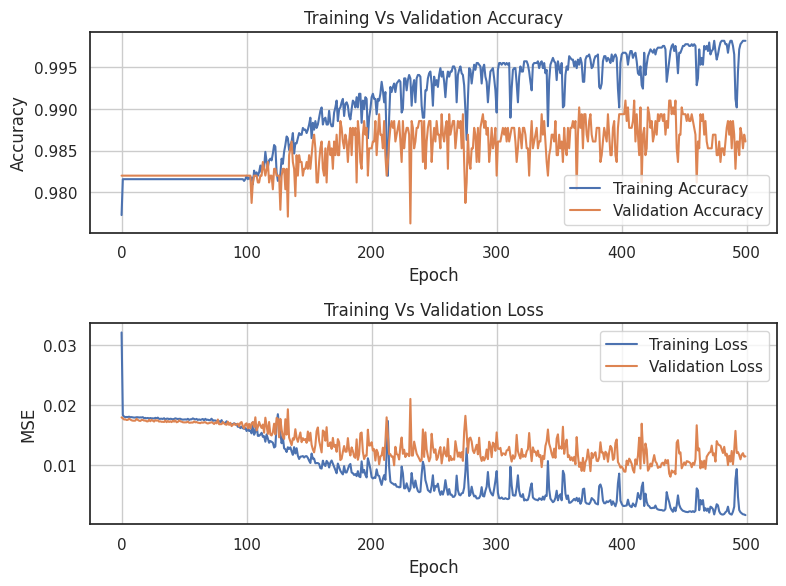

In [51]:
plot_train_validation_graph(history1, "Training_Vs_Validation_graph_lstm_feature_selection_500_epochs")

In [52]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

34/34 [==============================] - 0s 7ms/step - loss: 0.0121 - accuracy: 0.9870
Test accuracy: 0.9870


In [53]:
y_prediction = model.predict(X_test)

34/34 [==============================] - 0s 6ms/step


In [54]:
X_test.shape

(1079, 10, 10)

In [55]:
y_prediction.shape, y_test.shape

((1079, 1), (1079,))

In [56]:
y_predict = y_prediction.flatten()
y_predict.shape

(1079,)

In [57]:
y_predict = list(np.where(np.array(y_predict) > 0.5, 1, 0 ))
y_predict = np.array(y_predict)

In [58]:
y_predict.shape, y_test.shape

((1079,), (1079,))

In [59]:
dataframe = pd.DataFrame({
    "Actual_Load":y_test,
    "Predicted_Load":y_predict
})

In [60]:
dataframe

,Actual_Load,Predicted_Load
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1074,1,0
1075,1,0
1076,0,0
1077,0,0


In [61]:
dataframe["Actual_Load"].value_counts()

Actual_Load
0    1056
1      23
Name: count, dtype: int64

In [62]:
dataframe["Predicted_Load"].value_counts()

Predicted_Load
0    1068
1      11
Name: count, dtype: int64

In [63]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

Mean Squared Error: 0.012974976830398516
Root Mean Squared Error: 0.11390775579563718
Mean Absolute Error: 0.012974976830398516
R-squared Score: 0.3780467720685111


# Confustion Matrix

In [64]:
def display_evaluation(yt, yp):
    TN, FP, FN, TP = confusion_matrix(yt, yp).ravel()

    print("Model: ", model)

    print("Confusion Matix Values:")
    print("TN: ", TN)
    print("FP: ", FP)
    print("FN: ", FN)
    print("TP: ", TP)

    SE = TP/(TP+FN)  #sensitivity, recall, hit rate, or true positive rate (TPR)
    SP = TN/(TN+FP)  #specificity, selectivity or true negative rate (TNR)
    AC = (TP+TN)/(TP+TN+FP+FN)   #accuracy
    PR = TP/(TP+FP)   #precision, positive predictive value (PPV)
    BCR = 1/2*(SE+SP)   #balanced classification rate
    BER = 1-BCR   #balanced error rate
    F1 = 2*PR*SE/(PR+SE)   #F1 score
    FNR = 1-SE   #miss rate or false negative rate (FNR)
    FPR = 1-SP   #fall-out or false positive rate (FPR)
    TS = TP/(TP+FP+FN)   #Threat score (TS) or Critical Success Index (CSI)
    DC = 2*TP/(2*TP+FP+FN) #Dice Coefficient

    print("\nEvaluation Parameters:")
    print('Accuracy:{:.4f}'.format(AC))
    print('Sensitivity:{:.4f}'.format(SE))
    print('Specificity: {:.4f}'.format(SP))
    print('Precision: {:.4f}'.format(PR))
    print('F1 Score: {:.4f}'.format(F1))
    print('BCR: {:.4f}'.format(BCR))
    print('BER: {:.4f}'.format(BER))

In [65]:
display_evaluation(y_test, y_predict)

Model:  <keras.engine.sequential.Sequential object at 0x7f048ce8dd30>
Confusion Matix Values:
TN:  1055
FP:  1
FN:  13
TP:  10

Evaluation Parameters:
Accuracy:0.9870
Sensitivity:0.4348
Specificity: 0.9991
Precision: 0.9091
F1 Score: 0.5882
BCR: 0.7169
BER: 0.2831


# ROC Curve

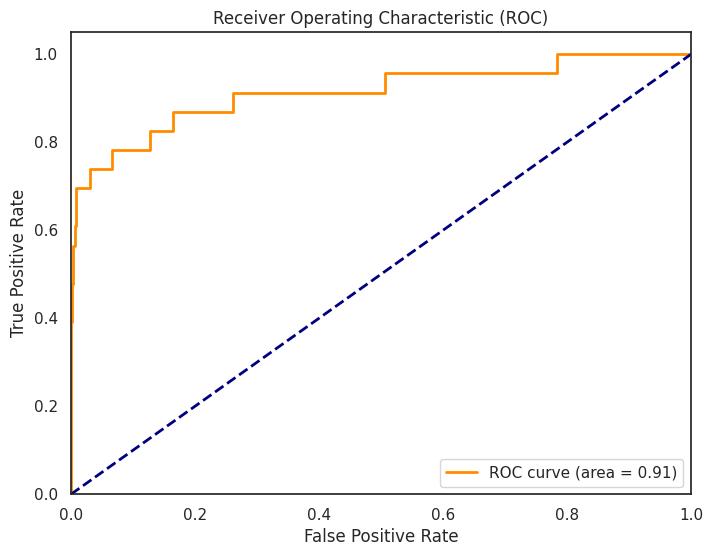

In [66]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prediction)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8,6), dpi = 100)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig("ROC_LSTM_2_feature_selection_500_epoches.png")
plt.show()

In [67]:
# Print classification report
print(classification_report(y_test, y_predict, target_names=['normal', 'anomaly']))

              precision    recall  f1-score   support

      normal       0.99      1.00      0.99      1056
     anomaly       0.91      0.43      0.59        23

    accuracy                           0.99      1079
   macro avg       0.95      0.72      0.79      1079
weighted avg       0.99      0.99      0.98      1079



# Confustion matrix

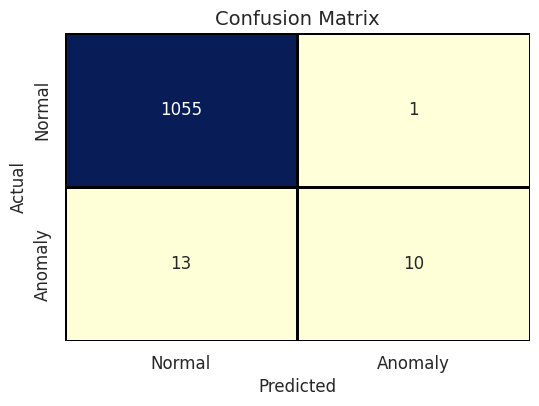

In [49]:
import seaborn as sns

# Define class labels
class_labels = ['Normal', 'Anomaly']

conf_matrix = confusion_matrix(y_test, y_predict)


# Set up a white grid with white text
sns.set(style="white")
plt.figure(figsize=(6, 4), dpi=100)

# Create a heatmap using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=False,
            annot_kws={"fontsize": 12}, linewidths=1, linecolor='black')

# Set custom tick labels for x-axis and y-axis
tick_labels = class_labels
plt.xticks(np.arange(len(tick_labels)) + 0.5, tick_labels, fontsize=12)
plt.yticks(np.arange(len(tick_labels)) + 0.5, tick_labels, fontsize=12)

# Add labels and title with increased font size
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)

# Set tick labels' font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("Confusion_matrix_lstm_2_feature_selection_500_epoches.png")
plt.show()
